<a href="https://colab.research.google.com/github/DJCordhose/mlops-drift/blob/main/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training, Re-Train on new data, re-engineer training

TODO:
1. KPI
   * good customer +1k$
   * bad customer -2k$
1. When dropping unimportant features also drop all columns not having the dominant value for that feature   

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
def url_for_dataset(relative_path):
  if IN_COLAB:
    url = f'https://github.com/DJCordhose/mlops-drift/raw/main/datasets/insurance_prediction/{relative_path}.csv.gz'
  else:
    url =  f'./datasets/insurance_prediction/{relative_path}.csv.gz'
  return url

In [3]:
# If this gives red output everything is fine
import tensorflow as tf
tf.__version__

2023-11-02 09:48:49.102555: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 09:48:49.105219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-02 09:48:49.170842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 09:48:49.170911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 09:48:49.170956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

'2.14.0'

In [4]:
# disable gpus, can also give red output and everything is just fine
tf.config.set_visible_devices([], 'GPU')

In [5]:
tf.random.set_seed(42)

In [6]:
import numpy as np
np.__version__

'1.26.1'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [8]:
if IN_COLAB:
    !pip install -q lrcurve

In [9]:
# https://github.com/AndreasMadsen/python-lrcurve
from lrcurve import KerasLearningCurve

# Step 1: Choosing data set to train on

In [10]:
use_new_data_for_training = False
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should start to show

In [11]:
import pandas as pd

if not use_new_data_for_training:
  # original (old) data
  df = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
else:
  # new data
  df = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')

# Step 2: Preparing data

In [12]:
# comment in or even add more dropped features

def drop_unimportant_features(df):
    # drop features that no longer have a significant impact on prediction to avoid overfitting
    # df.drop(['emergency_braking'], axis='columns', inplace=True)
    # df.drop(['training'], axis='columns', inplace=True)
    pass


In [13]:
drop_unimportant_features(df)
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'milage', 'risk', 'group_name', 'group', 'good_customer'],
      dtype='object')

In [14]:
y = df['group'].values  # categorical classification
y = df['good_customer'].values  # binary classification
y = df['risk'].values  # regression

np.unique(y, return_counts=True)

(array([0, 1, 2]), array([579, 489, 432]))

In [15]:
df.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns', inplace=True)

In [16]:

from sklearn.model_selection import train_test_split
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 6), (300, 6), (1200,), (300,))

# Step 3: Establishing baseline

In [17]:
LOW_RISK = 2
MEDIUM_RISK = 1
HIGH_RISK = 0

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [18]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)
base_clf = RandomClassifier()    
base_clf.score(X_test, y_test)

0.35

In [19]:
# just return most frequent value might be a baseline
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([463, 391, 346]))

In [20]:
class NaiveClassifier(ClassifierBase):
    def predict_single(self, x):
        return HIGH_RISK
base_clf = NaiveClassifier()    
base_clf.score(X_test, y_test)    

0.38666666666666666

In [21]:
class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        training, age, emergency_braking, braking_distance, power, miles = x
#         print(age, power, miles)
        if training: 
            return LOW_RISK
        if age < 30:
            if power > 130:
                return HIGH_RISK
            else:
                return MEDIUM_RISK
        if age > 50:
            return HIGH_RISK
        if emergency_braking:
            return LOW_RISK
        if miles > 50:
            return HIGH_RISK
        if miles > 30:
            return MEDIUM_RISK
        # default
        return LOW_RISK
base_clf = BaseLineClassifier() 
base_clf.score(X_test, y_test)

0.6166666666666667

# Step 4: Training Keras model

In [22]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
# takes mean and variance from X_train for normalization
normalizer.adapt(X_train)

In [23]:
# this output and output from next cell are the same
X_train.mean(axis=0), X_train.var(axis=0)

(array([  0.20916667,  35.19335633,   0.385     ,  39.83644709,
        135.2198109 ,  81.03311172]),
 array([1.65415972e-01, 1.63476799e+02, 2.36775000e-01, 2.32858873e+01,
        1.21906054e+03, 6.62599657e+02]))

In [24]:
normalizer.mean, normalizer.variance

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[  0.20916666,  35.193356  ,   0.385     ,  39.836445  ,
         135.21983   ,  81.033104  ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[1.6541603e-01, 1.6347684e+02, 2.3677497e-01, 2.3285885e+01,
         1.2190607e+03, 6.6259955e+02]], dtype=float32)>)

In [25]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation


num_features = X.shape[1]
dropout = 0.7
neurons_per_layer = 100
# neurons_per_layer = 50

model = tf.keras.Sequential()
model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(neurons_per_layer, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden3'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 hidden1 (Dense)             (None, 100)               700       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               1

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
%%time

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 50

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    # validation_data=(X_test, y_test),
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 15.3 s, sys: 3.18 s, total: 18.5 s
Wall time: 13.3 s


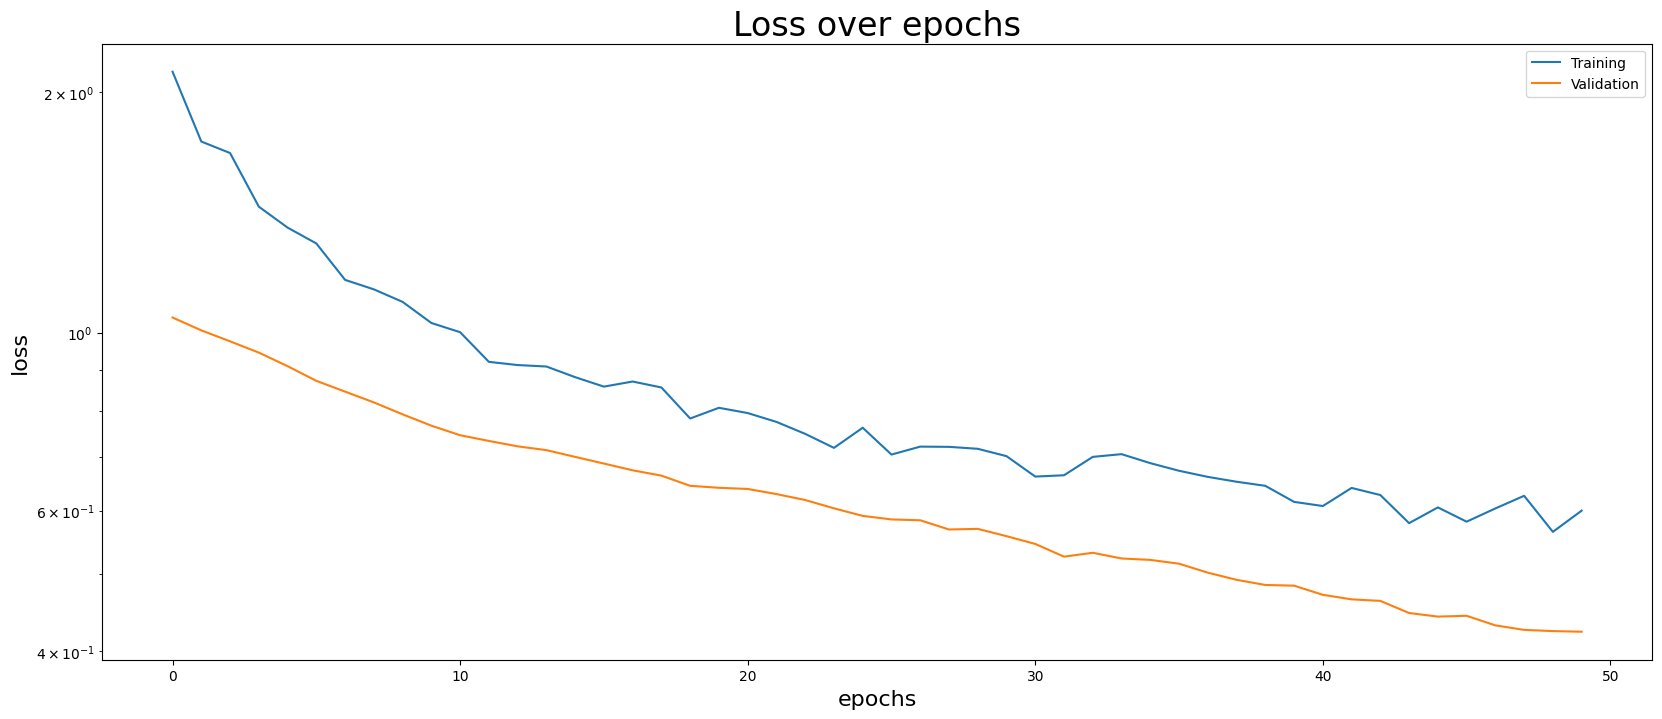

In [28]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

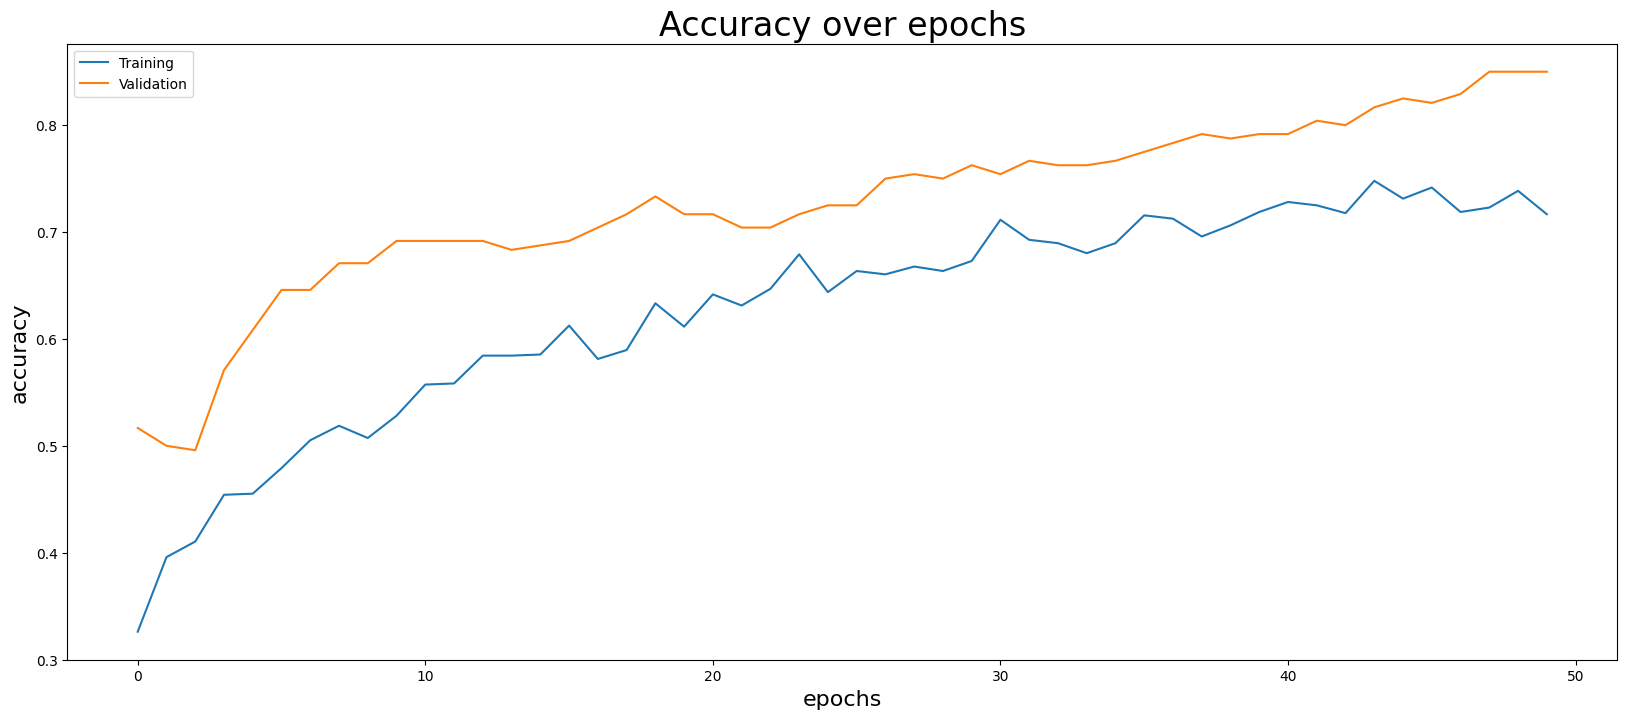

In [29]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation']);

In [30]:
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final validation accuracy: {val_accuracy * 100:.2f}%")
val_loss, val_accuracy

Final validation accuracy: 85.00%


(0.4232542812824249, 0.8500000238418579)

In [31]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 4ms/step - loss: 0.4051 - accuracy: 0.8625


(0.4051387906074524, 0.862500011920929)

In [32]:
test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 4ms/step - loss: 0.3641 - accuracy: 0.8800


(0.36413562297821045, 0.8799999952316284)

# Step 3: Choosing data set for evaluation

In [33]:
use_new_data = False
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should start to show

In [34]:
import pandas as pd

if not use_new_data:
  # original (old) data
  df = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
else:
  # new data
  df = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')


In [35]:
drop_unimportant_features(df)
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'milage', 'risk', 'group_name', 'group', 'good_customer'],
      dtype='object')

In [41]:
X = df.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns').values

In [42]:
y = df['group'].values
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([579, 489, 432]))

In [43]:
from sklearn.model_selection import train_test_split
# FIXME: does not make sense when this is a completely new dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 6), (300, 6), (1200,), (300,))

# Step 4: Choosing model to evaluate on
Options:
1. use pre-trained model from github (old model)
1. use whatever you have in this folder or anywhere in your file system
1. mount google drive

In [44]:
# !wget https://github.com/DJCordhose/mlops-drift/raw/main/notebooks/classifier.h5
# model_path = 'classifier'
# model = tf.keras.models.load_model(f'{model_path}.h5')

In [45]:
_, train_metric = model.evaluate(X_train, y_train, verbose=0)
train_metric

0.862500011920929

In [46]:
_, test_metric = model.evaluate(X_test, y_test, verbose=0)
test_metric

0.8799999952316284

# Step 5: Check Invariant Properties of Model

## Accuracy range and lack of overfitting

In [ ]:
# 85% is sufficient for our use case
assert train_metric > .85

In [ ]:
assert test_metric > .85

In [ ]:
assert abs(train_metric - test_metric) < .05

In [ ]:
# we can not be too good, this would be a suspicious

assert test_metric < .95
assert train_metric < .95

## Invariants of the model itself (without using data on it)
Could be
* effective depth of tree (if decision tree has been used as architecture instead of NN)
* distribution of weights
* actual normalization

**We do use these properties as we want to treat the model as a black box to make it interchangable**

## Invariants also useful for monitoring and analysis - not using GT

In [ ]:
y_pred = model.predict(X).argmax(axis=1)
y_pred.shape

### Distribution of Output Class

In [ ]:
values, counts = np.unique(y_pred, return_counts=True)
values, counts

In [ ]:
# equal distribution around classes expected
tolerance = 0.2
expected_count = len(X) / 3
lower_bound = int(expected_count * (1 - tolerance))
upper_bound = int(expected_count * (1 + tolerance))
print(f'{lower_bound}-{upper_bound}')

for count in counts:
    print(count)
    assert count in range(lower_bound, upper_bound)

# Step 6: Saving Model when validation holds

In [ ]:
model.save('classifier.h5', save_format='h5')

In [ ]:
model.save('classifier', save_format='tf')

In [ ]:
!tar czvf classifier.tgz ./classifier

In [ ]:
!ls -l